<h1>Extract image feature

In [70]:
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# ===== ĐƯỜNG DẪN =====
base = "coco2017/subset"
output_dir = f"{base}/features"
os.makedirs(output_dir, exist_ok=True)

# ===== LOAD MODEL =====
model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")

# ===== HÀM TRÍCH XUẤT FEATURES =====
def extract_features(img_dir, save_name):
    img_files = sorted([f for f in os.listdir(img_dir)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    features = []
    filenames = []

    for img_name in tqdm(img_files, desc=f"Extracting {save_name}"):
        img_path = os.path.join(img_dir, img_name)
        try:
            img = image.load_img(img_path, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)

            # Extract feature
            feat = model.predict(x, verbose=0)
            features.append(feat.flatten())
            filenames.append(img_name)
        except Exception as e:
            print(f"Lỗi ảnh {img_name}: {e}")

    features = np.array(features)
    np.savez(os.path.join(output_dir, f"{save_name}_features.npz"),
             features=features, filenames=np.array(filenames))
    print(f"✅ Saved {len(features)} features → {save_name}_features.npz")

# ===== CHẠY 3 TẬP =====
extract_features(f"{base}/train", "train")
extract_features(f"{base}/val", "val")
extract_features(f"{base}/test", "test")


Extracting train: 100%|██████████| 6400/6400 [08:23<00:00, 12.72it/s]


✅ Saved 6400 features → train_features.npz


Extracting val: 100%|██████████| 800/800 [01:04<00:00, 12.41it/s]


✅ Saved 800 features → val_features.npz


Extracting test: 100%|██████████| 800/800 [01:11<00:00, 11.14it/s]

✅ Saved 800 features → test_features.npz


<h1>Build Vocab

In [8]:
import os
os.environ["JAVA_HOME"] = "C:\\Program Files\\Java\\jdk-17"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["JAVA_HOME"], "bin", "server")

from python_rdrsegmenter import load_segmenter
segmenter = load_segmenter()
tokens = segmenter.tokenize("một người đàn ông trong áo sơ mi màu xanh và quần jean trên thang làm sạch cửa sổ")
tokens

'một người đàn_ông trong áo sơ_mi màu xanh và quần_jean trên thang làm sạch cửa_sổ'

In [10]:
import pandas as pd

df = pd.read_csv("captions_2017_full_en_vi.csv")
captions = df["caption_trans"].dropna().tolist()
print(f"Tổng số caption: {len(captions)}")

Tổng số caption: 616767


In [11]:
import re

lowered_captions = [segmenter.tokenize(re.sub(r'[.!?;:]', '', line.strip().lower().replace(",", " ,"))) for line in captions]
lowered_captions

['một bản_sao xe_đạp với một chiếc đồng_hồ làm bánh trước',
 'một căn phòng với những bức tường màu xanh và một bồn rửa và cửa màu trắng',
 'một chiếc xe dường_như được đậu bất_hợp_pháp đằng sau một chiếc xe đậu hợp_pháp',
 'một chiếc máy_bay chở khách lớn đang bay trên không',
 'có một chiếc máy_bay gol cất_cánh trên bầu_trời có một phần mây',
 'phối_màu xanh và trắng trong phòng tắm nhỏ',
 'đây là phòng tắm màu xanh và trắng với bồn rửa tường và phao cứu_sinh trên tường',
 'một phòng tắm theo chủ_đề thuyền xanh với một người bảo_vệ cuộc_sống trên tường',
 'chiếc xe_đạp có một cái đồng_hồ như một cái lốp',
 'hai chiếc xe đậu trên vỉa_hè , trên đường_phố',
 'một chiếc máy_bay vừa hạ_cánh vừa cất_cánh',
 'một phòng tắm với tường sơn màu xanh da_trời',
 'phòng tắm với nhà_vệ_sinh , bồn rửa và vòi_sen',
 'một căn bếp nhà dài trống_rỗng , tối_giản hiện_đại có ánh_sáng bầu_trời',
 'bồn rửa trong phòng tắm với đồ vệ_sinh cá_nhân trên quầy',
 'bồn rửa trong phòng tắm và các vật_dụng vệ_sinh c

In [15]:
lowered_captions_token = [lowered_captions_line.split() for lowered_captions_line in lowered_captions]
captions_length = [len(caption) for caption in lowered_captions_token]

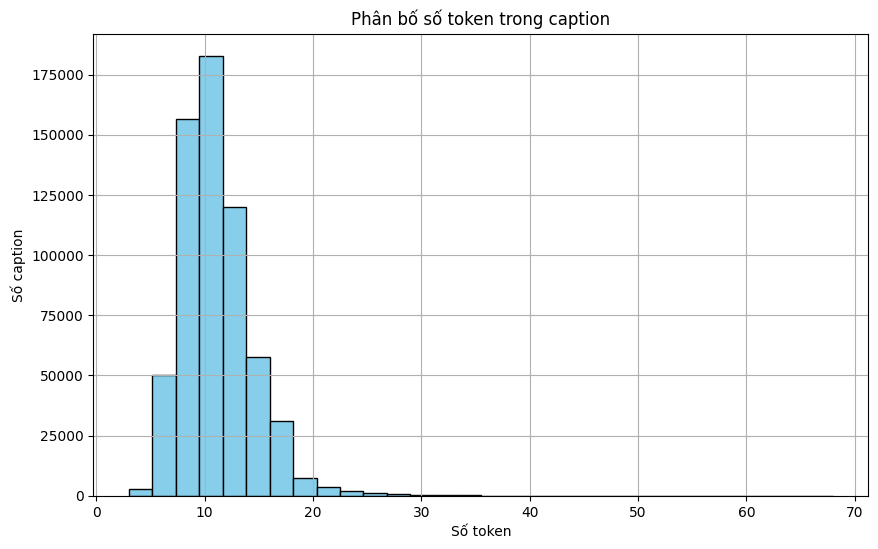

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(captions_length, bins=30, color='skyblue', edgecolor='black')
plt.title('Phân bố số token trong caption')
plt.xlabel('Số token')
plt.ylabel('Số caption')
plt.grid(True)
plt.show()

In [ ]:
word_freq = {}

for sentence in lowered_captions_token:
    for word in sentence:
        word_freq[word] = word_freq.get(word, 0) + 1

word_freq

{'một': 790937,
 'bản_sao': 61,
 'xe_đạp': 8557,
 'với': 142625,
 'chiếc': 106438,
 'đồng_hồ': 12852,
 'làm': 6861,
 'bánh': 20786,
 'trước': 22636,
 'căn': 7562,
 'phòng': 36905,
 'những': 25266,
 'bức': 19930,
 'tường': 9143,
 'màu': 56502,
 'xanh': 28885,
 'và': 139404,
 'bồn': 9868,
 'rửa': 9687,
 'cửa': 3480,
 'trắng': 32342,
 'xe': 18203,
 'dường_như': 544,
 'được': 36618,
 'đậu': 16556,
 'bất_hợp_pháp': 7,
 'đằng': 1771,
 'sau': 16101,
 'hợp_pháp': 4,
 'máy_bay': 12694,
 'chở': 3758,
 'khách': 9971,
 'lớn': 28720,
 'đang': 129221,
 'bay': 9482,
 'trên': 252106,
 'không': 6671,
 'có': 42631,
 'gol': 1,
 'cất_cánh': 1006,
 'bầu_trời': 6569,
 'phần': 1778,
 'mây': 2363,
 'phối_màu': 2,
 'trong': 118935,
 'tắm': 16791,
 'nhỏ': 23564,
 'đây': 3556,
 'là': 7704,
 'phao': 121,
 'cứu_sinh': 21,
 'theo': 7808,
 'chủ_đề': 250,
 'thuyền': 8936,
 'người': 205923,
 'bảo_vệ': 309,
 'cuộc_sống': 122,
 'cái': 51627,
 'như': 4655,
 'lốp': 268,
 'hai': 56799,
 'vỉa_hè': 5736,
 ',': 52980,
 'đường

In [ ]:
vocab = ["[PAD]", "[EOS]", "[SOS]", "[UNK]"]

for word, numb in word_freq.items():
    if numb >= 2:
        vocab.append(word)

print(vocab)

['[EOS]', '[SOS]', '[PAD]', '[UNK]', 'một', 'bản_sao', 'xe_đạp', 'với', 'chiếc', 'đồng_hồ', 'làm', 'bánh', 'trước', 'căn', 'phòng', 'những', 'bức', 'tường', 'màu', 'xanh', 'và', 'bồn', 'rửa', 'cửa', 'trắng', 'xe', 'dường_như', 'được', 'đậu', 'bất_hợp_pháp', 'đằng', 'sau', 'hợp_pháp', 'máy_bay', 'chở', 'khách', 'lớn', 'đang', 'bay', 'trên', 'không', 'có', 'cất_cánh', 'bầu_trời', 'phần', 'mây', 'phối_màu', 'trong', 'tắm', 'nhỏ', 'đây', 'là', 'phao', 'cứu_sinh', 'theo', 'chủ_đề', 'thuyền', 'người', 'bảo_vệ', 'cuộc_sống', 'cái', 'như', 'lốp', 'hai', 'vỉa_hè', ',', 'đường_phố', 'vừa', 'hạ_cánh', 'sơn', 'da_trời', 'nhà_vệ_sinh', 'vòi_sen', 'bếp', 'nhà', 'dài', 'trống_rỗng', 'tối_giản', 'hiện_đại', 'ánh_sáng', 'đồ', 'vệ_sinh', 'cá_nhân', 'quầy', 'các', 'vật_dụng', 'khác', 'nhau', 'hộp', 'mở', 'chứa', 'bốn', 'quả', 'dưa_chuột', 'ga', 'lá', 'cây', 'kiểu', 'cũ', 'đỗ', 'đường', 'lái_xe', 'râm', 'mát', 'bên', 'cạnh', 'bát', 'mặt', 'bàn', 'bằng', 'thép_không_gỉ', 'kim_loại_màu', 'đen', 'một_số', 'x

In [ ]:
with open("vocab.txt", "w", encoding="utf-8") as f:
    for word in vocab:
        f.write(word + "\n")

<h1>Preprocessing for train caption

In [1]:
# Load data

import pandas as pd
import numpy as np
import re

# original dataframe
df_original = pd.read_csv("captions_2017_full_en_vi.csv")
df_original = df_original[["file_name", "caption_trans"]]

# load train img features
train_img_data = np.load("coco2017/subset/features/train_features.npz", allow_pickle=True)
train_img_features = train_img_data["features"]
train_img_filenames = train_img_data["filenames"]

print("Train:")
print(train_img_features.shape)
print(train_img_filenames[:5])

train_df = pd.DataFrame({
    "file_name": train_img_filenames,
    "img_feature": list(train_img_features)
})
train_df = train_df.merge(df_original, on="file_name", how="inner")

# remove ".", lower, add space before ","
train_df["caption_trans"] = train_df["caption_trans"].apply(lambda line: re.sub(r'[.!?;:]', '', line.strip().lower().replace(",", " ,")))

# load val img features
val_img_data = np.load("coco2017/subset/features/val_features.npz", allow_pickle=True)
val_img_features = val_img_data["features"]
val_img_filenames = val_img_data["filenames"]

print("Val:")
print(val_img_features.shape)
print(val_img_filenames[:5])

val_df = pd.DataFrame({
    "file_name": val_img_filenames,
    "img_feature": list(val_img_features)
})

val_df = val_df.merge(df_original, on="file_name", how="inner")

# remove ".", lower, add space before ","
val_df["caption_trans"] = val_df["caption_trans"].apply(lambda line: re.sub(r'[.!?;:]', '', line.strip().lower().replace(",", " ,")))

Train:
(6400, 1280)
['000000000113.jpg' '000000000531.jpg' '000000000575.jpg'
 '000000000790.jpg' '000000000901.jpg']
Val:
(800, 1280)
['000000002197.jpg' '000000002982.jpg' '000000004477.jpg'
 '000000004716.jpg' '000000004760.jpg']


In [2]:
# tokenize caption_trans
import os
os.environ["JAVA_HOME"] = "C:\\Program Files\\Java\\jdk-17"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["JAVA_HOME"], "bin", "server")

from python_rdrsegmenter import load_segmenter
segmenter = load_segmenter()
# tokens = segmenter.tokenize("một người đàn ông , trong áo sơ mi màu xanh và quần jean trên thang làm sạch cửa sổ")
# tokens

In [3]:
train_df["caption_trans_tokenized"] = train_df["caption_trans"].apply(lambda x: segmenter.tokenize(x))
val_df["caption_trans_tokenized"] = val_df["caption_trans"].apply(lambda x: segmenter.tokenize(x))

In [4]:
with open("vocab.txt", "r", encoding="utf-8") as f:
    vocab = [line.strip() for line in f]

# Tạo map từ từ → id và ngược lại
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for i, w in enumerate(vocab)}

def encode_caption(caption_tokenized, word2idx, max_len=30):
    tokens = caption_tokenized.split()
    tokens = ["[SOS]"] + tokens + ["[EOS]"]

    # create a list of token_id
    token_ids = [word2idx.get(t, word2idx["[UNK]"]) for t in tokens]

    if len(token_ids) < max_len:
        # padding
        token_ids += [word2idx["[PAD]"]] * (max_len - len(token_ids))
    else:
        # truncate
        token_ids = token_ids[:max_len]

    return token_ids

# create token_ids column
train_df["token_ids"] = train_df["caption_trans_tokenized"].apply(lambda x: encode_caption(x, word2idx))
val_df["token_ids"] = val_df["caption_trans_tokenized"].apply(lambda x: encode_caption(x, word2idx))


In [5]:
train_df

,file_name,img_feature,caption_trans,caption_trans_tokenized,token_ids
0,000000000113.jpg,"[0.18025476, 0.09064608, 1.0495312, 0.19750194...",một người đàn ông và phụ nữ cắt thành một chiế...,một người đàn_ông và phụ_nữ cắt thành một chiế...,"[2, 4, 57, 122, 20, 194, 1225, 486, 4, 8, 11, ..."
1,000000000113.jpg,"[0.18025476, 0.09064608, 1.0495312, 0.19750194...",một người đàn ông và một phụ nữ đứng trước một...,một người đàn_ông và một phụ_nữ đứng trước một...,"[2, 4, 57, 122, 20, 4, 194, 345, 12, 4, 60, 11..."
2,000000000113.jpg,"[0.18025476, 0.09064608, 1.0495312, 0.19750194...",một người phụ nữ đang cắt vào một chiếc bánh,một người phụ_nữ đang cắt vào một chiếc bánh,"[2, 4, 57, 194, 37, 1225, 191, 4, 8, 11, 1, 0,..."
3,000000000113.jpg,"[0.18025476, 0.09064608, 1.0495312, 0.19750194...",hai người đứng gần một cái bàn với một chiếc bánh,hai người đứng gần một cái bàn với một chiếc bánh,"[2, 63, 57, 345, 251, 4, 60, 108, 7, 4, 8, 11,..."
4,000000000113.jpg,"[0.18025476, 0.09064608, 1.0495312, 0.19750194...",một người phụ nữ cắt vào một chiếc bánh với mộ...,một người phụ_nữ cắt vào một chiếc bánh với mộ...,"[2, 4, 57, 194, 1225, 191, 4, 8, 11, 7, 4, 57,..."
...,...,...,...,...,...
32013,000000581921.jpg,"[0.9953486, 0.29247954, 1.3998282, 0.7472482, ...",có một người đàn ông đang nhảy cẫng lên trên m...,có một người đàn_ông đang nhảy_cẫng lên trên m...,"[2, 41, 4, 57, 122, 37, 7515, 305, 39, 4, 8, 5..."
32014,000000581921.jpg,"[0.9953486, 0.29247954, 1.3998282, 0.7472482, ...",một người trượt tuyết đang ở trên không khi an...,một người trượt_tuyết đang ở trên không khi an...,"[2, 4, 57, 314, 37, 120, 39, 40, 270, 789, 335..."
32015,000000581921.jpg,"[0.9953486, 0.29247954, 1.3998282, 0.7472482, ...",người trượt tuyết nhảy lên không trung trên vá...,người trượt_tuyết nhảy lên không_trung trên vá...,"[2, 57, 314, 499, 305, 500, 39, 151, 152, 18, ..."
32016,000000581921.jpg,"[0.9953486, 0.29247954, 1.3998282, 0.7472482, ...",một người trượt tuyết nhảy cao vào một ngày tu...,một người trượt_tuyết nhảy_cao vào một ngày tu...,"[2, 4, 57, 314, 3175, 191, 4, 192, 321, 1411, ..."


<h1>Train

In [6]:
import numpy as np

training_img_features = np.stack(train_df["img_feature"].values)
training_caption_token_ids = np.stack(train_df["token_ids"].values)

validating_img_features = np.stack(val_df["img_feature"].values)
validating_caption_token_ids = np.stack(val_df["token_ids"].values)

X_train_img = training_img_features
X_train_seq = training_caption_token_ids[:, :-1] # truncate eos
Y_train_seq = training_caption_token_ids[:, 1:]

X_val_img = validating_img_features
X_val_seq = validating_caption_token_ids[:, :-1]
Y_val_seq = validating_caption_token_ids[:, 1:] # truncate sos

print("Train Shapes:")
print("X_img:", X_train_img.shape)
print("X_seq:", X_train_seq.shape)
print("Y_seq:", Y_train_seq.shape)

print("Val Shapes:")
print("X_img:", X_val_img.shape)
print("X_seq:", X_val_seq.shape)
print("Y_seq:", Y_val_seq.shape)

Train Shapes:
X_img: (32018, 1280)
X_seq: (32018, 29)
Y_seq: (32018, 29)
Val Shapes:
X_img: (4002, 1280)
X_seq: (4002, 29)
Y_seq: (4002, 29)


In [ ]:
from tensorflow.keras.layers import Input, Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

vocab_size = len(vocab)
embedding_dim = 256
hidden_dim = 512
seq_len = 29

# ---- Input Image ----
img_input = Input(shape=(1280,), name="image_features")
h0 = Dense(hidden_dim, activation="relu", name="img_dense")(img_input)  # initial hidden state

# ---- Input caption ----
seq_input = Input(shape=(seq_len,), name="input_sequence")
seq_emb = Embedding(vocab_size, embedding_dim, mask_zero=True, name="embedding")(seq_input)  # (batch, seq_len, 256)

# ---- Decoder RNN ----
rnn_layer = SimpleRNN(hidden_dim, return_sequences=True, name="decoder_rnn")
decoder = rnn_layer(seq_emb, initial_state=h0)  # gán h0 = vector ảnh
decoder = Dropout(0.3, name="dropout")(decoder)

# ---- Output ----
output = Dense(vocab_size, activation="softmax", name="output_dense")(decoder)

# ---- Model ----
model = Model(inputs=[img_input, seq_input], outputs=output, name="image_caption_model")
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

model.summary()

Model: "image_caption_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sequence (InputLayer)    [(None, 29)]         0           []                               
                                                                                                  
 image_features (InputLayer)    [(None, 1280)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 29, 256)      2841344     ['input_sequence[0][0]']         
                                                                                                  
 img_dense (Dense)              (None, 512)          655872      ['image_features[0][0]']         
                                                                                

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',  
    patience=3,           
    restore_best_weights=True 
)

model.fit(
    x=[X_train_img, X_train_seq],
    y=Y_train_seq,
    validation_data=([X_val_img, X_val_seq], Y_val_seq),
    batch_size=128,
    epochs=20,
    verbose=1,
    callbacks=[early_stop]
)

In [ ]:
import numpy as np
import tensorflow as tf

teacher_forcing_schedule = {
    1: 0.0,  2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0,
    6: 0.0,  7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0
}

# --- Config ---
epochs = len(teacher_forcing_schedule)
batch_size = 128
pad_token_id = 0
learning_rate = 1e-3

# --- Dataset train ---
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_img, X_train_seq, Y_train_seq))
train_dataset = train_dataset.shuffle(1000, seed=42).batch(batch_size, drop_remainder=True)

# --- Dataset val ---
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_img, X_val_seq, Y_val_seq))
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(learning_rate)

# --- get old model ---
embedding_layer = model.get_layer("embedding")
img_dense_layer = model.get_layer("img_dense")
rnn_cell = model.get_layer("decoder_rnn").cell
output_layer = model.get_layer("output_dense")

for epoch in range(1, epochs + 1):
    tf_prob = teacher_forcing_schedule[epoch]
    print(f"\nEpoch {epoch}: use {int(tf_prob*100)}% predicted tokens")

    total_loss = 0.0

    # --- epoch 10, decrease lr ---
    if epoch == 10:
        old_lr = optimizer.learning_rate.numpy()
        optimizer.learning_rate.assign(5e-4)
        print(f"\n[INFO] Giảm learning rate từ {old_lr} xuống {optimizer.learning_rate.numpy()}")

    # --- TRAIN LOOP ---
    for step, (img_batch, seq_in_batch, seq_out_batch) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            loss = 0.0

            seq_in_batch = tf.cast(seq_in_batch, tf.int64)
            seq_out_batch = tf.cast(seq_out_batch, tf.int64)

            # hidden init from image
            h = img_dense_layer(img_batch)
            dec_input = seq_in_batch[:, 0]  # start token

            for t in range(1, seq_len):
                # embedding
                x_t = embedding_layer(tf.expand_dims(dec_input, 1))
                x_t = tf.squeeze(x_t, axis=1)

                # rnn cell step
                output, [h] = rnn_cell(x_t, [h])

                # predict token
                y_pred = output_layer(tf.expand_dims(output, 1))
                y_pred = tf.squeeze(y_pred, axis=1)
                y_true = seq_out_batch[:, t]

                # ---- Mask padding ----
                mask = tf.cast(y_true != pad_token_id, tf.float32)

                # ---- Loss ----
                loss_t = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
                loss_t = tf.reduce_sum(loss_t * mask) / (tf.reduce_sum(mask) + 1e-8)
                loss += loss_t  

                # ---- Decide next input ----
                use_pred = tf.random.uniform(shape=[batch_size], seed=epoch * 1000 + step) < tf_prob
                y_pred_id = tf.argmax(y_pred, axis=-1)
                dec_input = tf.where(use_pred, y_pred_id, seq_in_batch[:, t])

            # average loss
            loss /= seq_len

        # ---- Update ----
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # ---- save ----
        total_loss += loss.numpy()

        if (step + 1) % 100 == 0:
            print(f"Step {step+1}, Loss: {total_loss/(step+1):.4f}")

    epoch_loss = total_loss / (step + 1)
    print(f"Epoch {epoch} TRAIN — Loss: {epoch_loss:.4f}")

    # --- VALIDATION LOOP ---
    val_loss = 0.0

    for img_batch, seq_in_batch, seq_out_batch in val_dataset:
        h = img_dense_layer(img_batch)
        dec_input = seq_in_batch[:, 0]  

        batch_loss = 0.0

        for t in range(1, seq_len):
            x_t = embedding_layer(tf.expand_dims(dec_input, 1))
            x_t = tf.squeeze(x_t, axis=1)
            output, [h] = rnn_cell(x_t, [h])
            y_pred = output_layer(tf.expand_dims(output, 1))
            y_true = seq_out_batch[:, t]

            # ---- Mask padding ----
            mask = tf.cast(y_true != pad_token_id, tf.float32)

            # ---- Loss ----
            loss_t = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
            loss_t = tf.reduce_sum(loss_t * mask) / (tf.reduce_sum(mask) + 1e-8)
            batch_loss += loss_t

            # ---- Always dùng output model cho val ----
            dec_input = tf.argmax(y_pred, axis=-1)[:, 0]

        batch_loss /= seq_len
        val_loss += batch_loss.numpy()

    val_loss /= len(val_dataset)
    print(f"Epoch {epoch} VAL — Loss: {val_loss:.4f}")


In [ ]:
test_data = np.load("coco2017/subset/features/test_features.npz", allow_pickle=True)
test_features = test_data["features"]
test_filenames = test_data["filenames"]

print("Test features:", test_features.shape)
print("Example:", test_filenames[:3])

Test features: (800, 1280)
Example: ['000000002217.jpg' '000000002290.jpg' '000000002429.jpg']


In [9]:
def generate_caption(model, image_feature, word2idx, idx2word, max_len=30):
    sos_id = word2idx["[SOS]"]
    eos_id = word2idx["[EOS]"]
    pad_id = word2idx["[PAD]"]

    seq = [sos_id]

    for i in range(max_len - 1):  # -1 vì có [SOS] rồi
        seq_padded = seq + [pad_id] * (max_len - len(seq) - 1)
        seq_padded = np.expand_dims(seq_padded, axis=0)
        img_input = np.expand_dims(image_feature, axis=0)

        preds = model.predict([img_input, seq_padded], verbose=0)
        next_token_id = np.argmax(preds[0, len(seq) - 1])

        seq.append(next_token_id)
        if next_token_id == eos_id:
            break

    # Decode
    caption = [idx2word[t] for t in seq if t not in [sos_id, eos_id, pad_id]]
    return " ".join(caption)

In [11]:
generated_captions = []

for i, (feature, fname) in enumerate(zip(test_features, test_filenames)):
    caption = generate_caption(model, feature, word2idx, idx2word)
    generated_captions.append({"file_name": fname, "caption": caption})
    if i == 400:
        break
    if i % 50 == 0:
        print(f"Processed {i}/{len(test_filenames)}")

# Chuyển thành DataFrame để dễ lưu
import pandas as pd
df_pred = pd.DataFrame(generated_captions)
df_pred.head()

Processed 0/800
Processed 50/800
Processed 100/800
Processed 150/800
Processed 200/800
Processed 250/800
Processed 300/800
Processed 350/800


,file_name,caption
0,000000002217.jpg,một phòng tắm với bồn rửa và gương
1,000000002290.jpg,một chiếc thuyền nhỏ đang đi trên một con sông
2,000000002429.jpg,một nhà_bếp với một cái bàn với một cái bàn và...
3,000000005587.jpg,một cái bàn với một đĩa thức_ăn và một cái nĩa
4,000000008599.jpg,một người đàn_ông ngồi trên một chiếc xe_máy


In [12]:
df_pred.to_csv("predicted_captions.csv", index=False, encoding="utf-8")

In [8]:
df_pred = pd.read_csv("predicted_captions.csv")

In [6]:
df_original

,file_name,caption_trans
0,000000203564.jpg,Một bản sao xe đạp với một chiếc đồng hồ làm b...
1,000000322141.jpg,Một căn phòng với những bức tường màu xanh và ...
2,000000016977.jpg,Một chiếc xe dường như được đậu bất hợp pháp đ...
3,000000106140.jpg,Một chiếc máy bay chở khách lớn đang bay trên ...
4,000000106140.jpg,Có một chiếc máy bay GOL cất cánh trên bầu trờ...
...,...,...
616762,000000009590.jpg,Một nhóm người đàn ông nhấm nháp đồ uống và nó...
616763,000000084664.jpg,"Một đĩa thức ăn với một ít trứng, khoai tây, b..."
616764,000000331569.jpg,Dâu tây đang ngồi bên cạnh ly sữa lắc cao.
616765,000000231237.jpg,Một bó hoa nhỏ màu đỏ trong một bình đất sét h...


In [9]:
df_pred

,file_name,caption
0,000000002217.jpg,một phòng tắm với bồn rửa và gương
1,000000002290.jpg,một chiếc thuyền nhỏ đang đi trên một con sông
2,000000002429.jpg,một nhà_bếp với một cái bàn với một cái bàn và...
3,000000005587.jpg,một cái bàn với một đĩa thức_ăn và một cái nĩa
4,000000008599.jpg,một người đàn_ông ngồi trên một chiếc xe_máy
...,...,...
396,000000300012.jpg,một người đàn_ông đang trượt ván trên một con ...
397,000000300415.jpg,một con gấu bông ngồi trên một cái bàn gỗ
398,000000301724.jpg,một chiếc xe_đạp màu đỏ đậu cạnh một chiếc xe_tải
399,000000301885.jpg,một người đàn_ông đang đứng trên bãi biển


In [ ]:
gt_dict = (
    df_original
    .groupby("file_name")["caption_trans"]
    .apply(list)
    .to_dict()
)

gt_dict

y_true = []
y_pred = []

for _, row in df_pred.iterrows():
    fname = row["file_name"]
    pred_caption = row["caption"].split()

    if fname not in gt_dict:
        continue

    refs = gt_dict[fname]
    refs = [segmenter.tokenize(re.sub(r'[.!?;:]', '', line.strip().lower().replace(",", " ,"))).split() for line in refs]

    y_pred.append(pred_caption)
    y_true.append(refs)


{'000000000009.jpg': ['Cận cảnh các thùng thực phẩm bao gồm bông cải xanh và bánh mì.',
  'Một bữa ăn được trình bày trong khay nhựa màu sắc rực rỡ.',
  'Có những hộp chứa đầy các loại thực phẩm khác nhau.',
  'Các món ăn đầy màu sắc chứa thịt, rau, trái cây và bánh mì.',
  'Một đống khay đựng thức ăn khác nhau.'],
 '000000000025.jpg': ['Một con hươu cao cổ ăn thức ăn từ trên đỉnh cây.',
  'Một con hươu cao cổ đứng gần một cái cây.',
  'Một con hươu cao cổ mẹ với con của nó trong rừng.',
  'Hai con hươu cao cổ đứng trong một khu vực đầy cây.',
  'Một con hươu cao cổ đứng cạnh một khu rừng đầy cây.'],
 '000000000030.jpg': ['Một bình hoa đang ngồi trên giá đỡ hiên nhà.',
  'Bình hoa màu trắng với hoa màu khác nhau ngồi bên trong của nó. ',
  'Một bình hoa trắng với nhiều hoa trên sân khấu.',
  'Một bình hoa màu trắng chứa đầy hoa màu khác nhau.',
  'Một bình hoa với hoa màu đỏ và trắng bên ngoài vào một ngày nắng.'],
 '000000000034.jpg': ['Một con ngựa vằn gặm cỏ xanh tươi trên cánh đồng

In [26]:
y_true

[[['một',
   'phòng',
   'tắm',
   'với',
   'bồn_tắm',
   'và',
   'bồn',
   'rửa',
   'mặt',
   'bên',
   'trong'],
  ['một',
   'phòng',
   'tắm',
   'với',
   'bồn',
   'rửa',
   ',',
   'bồn_tắm',
   'và',
   'gương',
   'trong',
   'đó'],
  ['phòng',
   'tắm',
   'với',
   'bàn',
   'trang_điểm',
   'đôi',
   'và',
   'bồn_tắm',
   'trong',
   'vườn'],
  ['một',
   'cái',
   'nhìn',
   'tại',
   'một',
   'phòng',
   'tắm',
   'đã',
   'được',
   'làm',
   'sạch',
   'mới'],
  ['một', 'phòng', 'tắm', 'có', 'bồn_tắm', 'lớn', 'trong', 'đó']],
 [['một',
   'chiếc',
   'thuyền_buồm',
   'đậu',
   'bên',
   'cạnh',
   'một',
   'bến_tàu',
   'và',
   'các',
   'tàu_thuyền',
   'khác'],
  ['một', 'chiếc', 'thuyền', 'nhỏ', 'đang', 'ngồi', 'trên', 'mặt_nước'],
  ['một', 'chiếc', 'thuyền', 'đang', 'trôi_nổi', 'trên', 'mặt_nước'],
  ['một', 'chiếc', 'thuyền', 'nhỏ', 'trong', 'một', 'vùng', 'nước', 'hẹp'],
  ['một', 'chiếc', 'thuyền', 'ngồi', 'trên', 'mặt_nước', 'gần', 'bến_tàu']],
 [['nhà_

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

smooth = SmoothingFunction().method1
bleu = corpus_bleu(y_true, y_pred, smoothing_function=smooth)

weights_list = [
    (1.0, 0, 0, 0),          # BLEU-1
    (0.5, 0.5, 0, 0),        # BLEU-2
    (0.33, 0.33, 0.33, 0),   # BLEU-3
    (0.25, 0.25, 0.25, 0.25) # BLEU-4
]

for i, w in enumerate(weights_list, 1):
    score = corpus_bleu(y_true, y_pred, weights=w, smoothing_function=smooth)
    print(f"BLEU-{i}: {score:.4f}")


BLEU-1: 0.5984
BLEU-2: 0.4464
BLEU-3: 0.3255
BLEU-4: 0.2225


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Phuong\miniconda3\envs\dat301m\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Phuong\miniconda3\envs\dat301m\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Phuong\miniconda3\envs\dat301m\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Phuong\miniconda3\envs\dat301m\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [